# Prepare data directory

In [1]:
from itertools import chain
import json
import os
import shutil
from tqdm.notebook import tqdm
import yaml
import numpy as np
import os, os.path
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random
import time

In [2]:
class SDataset:
    def __init__(self, images_path: str, annotations_filepath: str,
                imdata_path: str, dataset_name: str = "SHdataset",
                num_classes:int = 3, image_size = (512, 512), allow_unlabeled:bool = False):
        # Inputs:
        #   images_path - path to image directory
        #   annotation_path - path to images annotation file
        #   imdata_path - path to file containing data about images
        self.allow_unlabeled = allow_unlabeled
        self.split_mask_to_instances = False
        self.dataset_name = dataset_name
        self.image_size = image_size
        self.images_path = images_path
        self.annotations_filepath = annotations_filepath
        self.imdata_path = imdata_path

        self.dataset_dirpath = os.path.join(os.getcwd(), self.dataset_name)

        self.labeled_dirpath =  os.path.join(self.dataset_dirpath, "labeled")
        if self.allow_unlabeled:
            self.unlabeled_dirpath =  os.path.join(self.dataset_dirpath, "unlabeled")

        self.sample_data = pd.read_csv(imdata_path)
        self.num_classes = num_classes

        self.classes_dict = {
            "blood_vessel": 0,
            "glomerulus": 1,
            "unsure": 2,
        }

        self.polygons = dict((item['id'], item) for item
                             in self.parse_jsonl(annotations_filepath))


    def parse_jsonl(self, path: str) -> list[dict]:
        with open(path, 'r') as json_file:
            jsonl_samples = [
                json.loads(line)
                for line in tqdm(
                    json_file, desc="Processing polygons"
                )
            ]
        print("Found " + str(len(jsonl_samples))+ " samples containing polygons.")
        return jsonl_samples


    def __prepare_dirs(self) -> None:
        # Create structure for coco dataset
        if not os.path.exists(self.dataset_dirpath):
            os.makedirs(os.path.join(self.labeled_dirpath, "images"), exist_ok=True)
            os.makedirs(os.path.join(self.labeled_dirpath, "masks"), exist_ok=True)
            if self.split_mask_to_instances:
                os.makedirs(os.path.join(self.labeled_dirpath, "instances"), exist_ok=True)
            if self.allow_unlabeled:
                os.makedirs(os.path.join(self.unlabeled_dirpath, "images"), exist_ok=True)
        else:
            raise RuntimeError()


    @staticmethod
    def __copy_image(source: str, destination:str) -> str:
        shutil.copyfile(
          source,
          destination
        )


    @staticmethod
    def __save_mask(dst_path:str, file_name:str, mask: np.ndarray) -> None:
        np.save(os.path.join(dst_path,file_name), mask)


    def __instances_from_annotation(self, annotations: dict,
                         size: tuple[int, int])->np.ndarray:
        masks = {
        0: [],
        1: [],
        2: []
        }
        for annotation in annotations:
            mask = Image.new(mode='1', size=size)
            en_type = self.classes_dict[annotation["type"]]
            coords = np.ravel(np.array(annotation["coordinates"][0]))
            ImageDraw.Draw(mask, '1').polygon(coords.tolist(), fill=(1))
            masks[en_type].append(np.array(mask))
        return np.array(masks)

    def __mask_from_annotation(self, annotations: dict,
                             size: tuple[int, int])->np.ndarray:
        masks = [Image.new(mode='1', size=size) for i in range(self.num_classes)]
        for annotation in annotations:
            en_type = self.classes_dict[annotation["type"]]
            coords = np.ravel(np.array(annotation["coordinates"][0]))
            ImageDraw.Draw(masks[en_type], '1').polygon(coords.tolist(), fill=(1))
        return np.stack([np.array(mask) for mask in masks], axis=2).astype(float)


    def __split_folders(self)->None:
        if self.allow_unlabeled:
            pbar = tqdm(desc="Preparing data", total=self.sample_data.shape[0])
        else:
            pbar = tqdm(desc="Preparing data", total=len(self.polygons))

        for sample_id, sample_dataset in zip(self.sample_data['id'],
                                             self.sample_data['dataset']):
            impath = os.path.join(self.images_path, f"{sample_id}.tif")
            if sample_dataset in [1, 2]:
                dest_path = self.labeled_dirpath
            elif sample_dataset == 3:
                if self.allow_unlabeled:
                    dest_path = self.unlabeled_dirpath
                else: continue
            else:
                raise RuntimeError(f"Unknown sample dataset for sample {sample_id}")

            self.__copy_image(impath, os.path.join(dest_path, "images", f"{sample_id}.tif"))

            if sample_dataset in [1,2]:
                annotations = self.polygons.get(sample_id).get("annotations")
                mask = self.__mask_from_annotation(annotations, self.image_size)
                self.__save_mask(os.path.join(dest_path, "masks"), sample_id, mask)
                if self.split_mask_to_instances:
                    instances = self.__instances_from_annotation(annotations, self.image_size)
                    self.__save_mask(os.path.join(dest_path, "instances"), sample_id, instances)
            pbar.update(1)
        pbar.close()


    def __count_dataset(self) -> dict:
        labeled_images = len(os.listdir(os.path.join(self.labeled_dirpath, "images")))
        labeled_masks = len(os.listdir(os.path.join(self.labeled_dirpath, "masks")))
        if self.allow_unlabeled:
            unlabeled_images = len(os.listdir(os.path.join(self.unlabeled_dirpath, "images")))
            return {
            "labeled_images": labeled_images,
            "labeled_masks": labeled_masks,
            "unlabeled_images": unlabeled_images
            }
        else:
            return {
            "labeled_images": labeled_images,
            "labeled_masks": labeled_masks
            }


    @staticmethod
    def print_dataset(dataset:dict)->None:
        for k in dataset:
            print(f"{k}: {dataset[k]}\n")

    @staticmethod
    def __check_sanity(count_dict: dict) -> None:
        assert count_dict["labeled_images"] == count_dict["labeled_masks"]


    def create_dataset(self):
        try:
            self.__prepare_dirs()
        except RuntimeError:
            inp = input("Dataset with name "+self.dataset_name+" already exists.\n"+
                          "Do you want to override old dataset? y/n \n")
            if inp == "y":
                shutil.rmtree(self.dataset_name)
                self.__prepare_dirs()
            else: raise RuntimeError("Dataset already exists!")

        self.__split_folders()
        count_dict = self.__count_dataset()
        self.__check_sanity(count_dict)
        self.print_dataset(count_dict)

In [3]:
ds = SDataset(
  annotations_filepath="/kaggle/input/hubmap-hacking-the-human-vasculature/polygons.jsonl",
  images_path="/kaggle/input/hubmap-hacking-the-human-vasculature/train",
  imdata_path = "/kaggle/input/hubmap-hacking-the-human-vasculature/tile_meta.csv",
)

ds.create_dataset()

Processing polygons: 0it [00:00, ?it/s]

Found 1633 samples containing polygons.


Preparing data:   0%|          | 0/1633 [00:00<?, ?it/s]

labeled_images: 1633

labeled_masks: 1633



# Create dataset and dataloader

In [4]:
import glob
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
class LabeledDataset(torch.utils.data.Dataset):

    def __init__(self, image_paths: list[str], mask_paths: list[str], transform=None,
                 classes: list[int]=[0, 1, 2]):

        self.classes = classes

        self.transforms = transform

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        
    @classmethod
    def from_root(cls, root:str, transform=None,
                 classes: list[int]=[0, 1, 2], max_size:int=None):
        image_paths = sorted(glob.glob(os.path.join(root,'labeled','images','*.tif')))
        mask_paths = sorted(glob.glob(os.path.join(root,'labeled', 'masks','*.npy')))
        if max_size:
            image_paths = image_paths[0:max_size]
            mask_paths = mask_paths[0:max_size]

        assert len(image_paths) == len(mask_paths)
        return cls(image_paths, mask_paths, transform=transform, classes=classes)
        
    @classmethod
    def from_paths(cls, image_paths: list[str], mask_paths: list[str],
                   transform=None, classes: list[int]=[0, 1, 2],):
        image_paths = sorted(image_paths)
        mask_paths = sorted(mask_paths)

        assert len(image_paths) == len(mask_paths)
        return cls(image_paths, mask_paths, transform=transform, classes=classes)

    def __len__(self):
        return len(self.image_paths)

    @staticmethod
    def create_semantic_masks(mask:np.ndarray, size:tuple[int, int]=(512, 512))->np.ndarray:
        semantic_masks = []
        for key, value in mask.tolist().items():
            if value:
                semantic_masks.append(np.sum(value, axis=0))
            else:
                semantic_masks.append(np.zeros(size))
        return np.array(semantic_masks)


    def __getitem__(self, index: int)->tuple[np.ndarray, np.ndarray]:
        img = np.array(Image.open(self.image_paths[index]))
        mask = np.take(np.load(self.mask_paths[index]), self.classes, axis = 2)
        #mask = np.load(self.mask_paths[index])
        #if len(self.classes) == 1:
         #   mask = np.squeeze(mask)
        if self.transforms is not None:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        return img, mask

In [6]:
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, transform=None, max_size = None):
        self.root = root
        self.max_size = max_size

        self.all_paths = sorted(glob.glob(os.path.join(self.root,
                                                             'images','*.tif')))
        if not self.max_size:
            self.image_paths = self.all_paths
        else:
            self.image_paths = self.all_paths[0:max_size]

    def set_max_size(self, max_size: int) -> None:
        self.max_size = max_size
        self.image_paths = self.all_paths[0:self.max_size]

    def get_for_labeling(self, size) -> list[str]:
        # get list of unlabeled images paths and remove them from set
        for_labeling = self.image_paths[0:size]
        self.image_paths = self.image_paths[size:]
        return(for_labeling)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index: int)->tuple[np.ndarray, np.ndarray]:
        img = np.array(Image.open(self.image_paths[index]))
        return img

In [7]:
def get_datasets(root: str, shuffle: bool = False, transforms = (None, None),
                classes: list[int] = [0,1,2], sizes:tuple[int,int] = None
                ) -> tuple[LabeledDataset, LabeledDataset]:

    image_paths = sorted(glob.glob(os.path.join(root,'images','*.tif')))
    mask_paths = sorted(glob.glob(os.path.join(root,'masks','*.npy')))
    assert len(image_paths) == len(mask_paths)
          
    if shuffle:
        _temp = list(zip(image_paths, mask_paths))
        random.shuffle(_temp)
        image_paths, mask_paths = [list(paths) for paths in zip(*_temp)]

    d_len = len(image_paths)

    if sizes:
        assert sizes[0] + sizes[1] <= d_len
    else:
        sizes = [int(0.8 * d_len), d_len - int(0.8 * d_len)]
        assert sizes[0] + sizes[1] == d_len

    train_l_dataset = LabeledDataset.from_paths(image_paths[0:sizes[0]], 
                                                mask_paths[0:sizes[0]],
                                                transform = transforms[0],
                                                classes = classes)

    train_v_dataset = LabeledDataset.from_paths(image_paths[sizes[0]:sizes[0]+sizes[1]],
                                                mask_paths[sizes[0]:sizes[0]+sizes[1]], 
                                                transform = transforms[0], 
                                                classes = classes)
    return train_l_dataset, train_v_dataset

In [8]:
def get_mean_std(num_channels:int)->tuple[np.ndarray, np.ndarray]:
    transform_data_mean_std = A.Compose([
      ToTensorV2()
    ])
    
    labeled_data = LabeledDataset.from_root(root = '/kaggle/working/SHdataset')
    full_loader = torch.utils.data.DataLoader(labeled_data)

    mean = torch.zeros(num_channels)
    std = torch.zeros(num_channels)

    for inputs, _ in tqdm(full_loader, desc = "Computing mean and std"):
        inputs = inputs.float()
        for i in range(num_channels):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(full_loader))
    std.div_(len(full_loader))
    print("Found mean: ", mean.div_(255.0))
    print("Found std: ", std.div_(255.0))
    return np.array(mean.div_(255.0)), np.array(std.div_(255.0))

In [9]:
mean, std = get_mean_std(3)

Computing mean and std:   0%|          | 0/1633 [00:00<?, ?it/s]

Found mean:  tensor([0.5800, 0.5799, 0.5798])
Found std:  tensor([0.1928, 0.1916, 0.1924])


In [10]:
mean = [0.5800, 0.5799, 0.5798]
std = [0.1928, 0.1916, 0.1924]

In [11]:
train_transforms = A.Compose([
    A.OneOf([A.augmentations.crops.transforms.CropNonEmptyMaskIfExists(224, 224, always_apply=True, p=1.0),
             A.augmentations.crops.transforms.RandomCrop(224, 224, p=1.0)], p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(transpose_mask = True)
])

val_transforms = A.Compose([
    A.OneOf([A.augmentations.crops.transforms.CropNonEmptyMaskIfExists(224, 224, always_apply=True, p=1.0),
             A.augmentations.crops.transforms.RandomCrop(224, 224, p=1.0)], p=1.0),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(transpose_mask = True)
])

# Metrics

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

In [13]:
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True, add_sigmoid = False):
        self.add_sigmoid = add_sigmoid
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        if self.add_sigmoid:
            inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.contiguous().flatten()
        targets = targets.contiguous().flatten()

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, add_sigmoid = False):
        self.add_sigmoid = add_sigmoid
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        if self.add_sigmoid:
            inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice


class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True, add_sigmoid = False):
        self.add_sigmoid = add_sigmoid
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        if self.add_sigmoid:
            inputs = F.sigmoid(inputs)
        #flatten label and prediction tensors
        inputs = inputs.clone().view(-1).to(dtype=torch.float32)
        targets = targets.clone().view(-1).to(dtype=torch.float32)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

####################
ALPHA = 0.7
BETA = 0.3
GAMMA = 4/3
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, add_sigmoid = False):
        self.add_sigmoid = add_sigmoid
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):

        if self.add_sigmoid:
            inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.contiguous().flatten()
        targets = targets.contiguous().flatten()

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
        FocalTversky = (1 - Tversky)**gamma

        return FocalTversky

# Training

In [14]:
import random
import time
from collections import defaultdict

In [15]:
def metrics_description(metrics:dict, epoch_samples: int, phase:str)->str:
    outputs = phase + ": ||"
    for k in metrics.keys():
        outputs += (" {}: {:4f} ||".format(k, metrics[k] / epoch_samples))
    return outputs

In [16]:
def reverse_transform(inp: np.ndarray, im_type: str, mean: np.ndarray=None,
                      std: np.ndarray=None):
    inp = inp.permute(1, 2, 0).numpy()
    if im_type == 'img':
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        inp = (inp * 255).astype(np.uint8)
    return inp

In [25]:
def train(model:nn.Module, model_name:str, dataset_root:str, checkpoints:bool = False,
          checkpoint_interval = 5, plot_example_after_epoch:bool = True, classes:int = [0,1,2]):
    try:
        gc.collect()
        torch.cuda.empty_cache()
    except:
        pass

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model().to(device)
    epochs = 20
    model_name = model_name
    num_classes = len(classes)
    ##############################################################################
                              ## Saving setting ##
    if checkpoints:
        checkpoints_path = os.path.join(os.getcwd(), "checkpoints_"+model_name)


    ##############################################################################
                              ## set up loss and metric ##
    FT =  FocalTverskyLoss(add_sigmoid=True).to(device)
    jaccard = IoU(add_sigmoid=True).to(device)
    diceBCE = DiceBCELoss(add_sigmoid=True).to(device)
    dice = DiceLoss(add_sigmoid=True).to(device)
    best_loss = 1e10
    
    metric_list = {'train': [],
                   'val': [],
                   'samples': []}
    ##############################################################################
                              ## LOAD DATASETS ##
    t_loader, v_loader = get_datasets(
        root = dataset_root,
        shuffle = True,
        transforms = (train_transforms, val_transforms),
        classes=classes,
        sizes = None
        )
    labeled_loaders = {
        'train':  torch.utils.data.DataLoader(t_loader, batch_size=1, shuffle=True),
        'val': torch.utils.data.DataLoader(v_loader, batch_size=1, shuffle=True)
    }

    ##############################################################################
                          ## OPTIMIZER AND SHELDUER ##

    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
                                            max_lr=1e-2, epochs=epochs, steps_per_epoch=len(labeled_loaders["train"]))


  #############################################################################
    print(" ____________________________________________________________")
    print("|                          Training                          |")
    print("|____________________________________________________________|")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}: ")
        since = time.time()
        #Each epoch has a training and validation phase
        for phase in ['train','val']: #, 'val'
            print("Phase: "+ phase)
            # Set model to phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            with tqdm(labeled_loaders[phase], unit = "batch",
                    total = len(labeled_loaders[phase])) as tepoch:
                for inputs, labels in labeled_loaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(torch.double).to(device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss =  FT(outputs, labels)
                        iou = jaccard(outputs, labels)
                        dbce_l = diceBCE(outputs, labels)
                        dice_l = dice(outputs, labels)

                    metrics['dice'] += dice_l.clone().detach().cpu().numpy()
                    metrics['diceBCE'] += dbce_l.clone().detach().cpu().numpy()
                    metrics['IoU']  += iou.clone().detach().cpu().numpy()
                    metrics['FT']  += loss.clone().detach().cpu().numpy()
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                    epoch_samples += inputs.size(0)
                    tepoch.set_description(metrics_description(metrics,
                                                              epoch_samples,
                                                              phase))
                    tepoch.update(inputs.size(0))
            
            metric_list[phase].append(metrics)
            print(metrics_description(metrics, epoch_samples, phase))
            print("-----"*10)
        metric_list['samples'].append(epoch_samples)
        epoch_loss = metrics['FT'] / epoch_samples

        if plot_example_after_epoch:
            for inputs, labels in labeled_loaders["val"]:
                inputs = inputs.to(device)
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    fig, ax = plt.subplots(1,2+num_classes, figsize = (5+5*num_classes,5))
                    ax[0].imshow(reverse_transform(inputs[0].cpu(), 'img', mean, std))
                    ax[1].imshow(labels[0].permute(1,2,0))
                    outs = reverse_transform(outputs[0].cpu(), 'mask')
                    if len(outs.shape) == 2:
                        ax[2].imshow(outs)
                    else:
                        for i in range(num_classes):        
                            ax[2+i].imshow(outs[:,:,i])
                    plt.show()
                break

        if epoch_loss < best_loss:
            best_loss = epoch_loss
        if checkpoints and (epoch % checkpoint_interval==0):
            os.makedirs(os.path.join(checkpoints_path,str(epoch),"model_params"), exist_ok=True)
            os.makedirs(os.path.join(checkpoints_path,str(epoch),"optim"), exist_ok=True)
            os.makedirs(os.path.join(checkpoints_path,str(epoch),"dataloader"), exist_ok=True)
            os.makedirs(os.path.join(checkpoints_path,str(epoch),"losses"), exist_ok=True)

            torch.save(model.state_dict(), os.path.join(checkpoints_path,str(epoch),
                                                      "model_params",
                                                      model_name+'_parameters.pt'))

            torch.save(optimizer, os.path.join(checkpoints_path,str(epoch),
                                             "optim", 'optim.pth'))
            torch.save(scheduler, os.path.join(checkpoints_path,str(epoch),
                                             "optim", 'sheld.pth'))

            torch.save(t_loader, os.path.join(checkpoints_path,str(epoch),
                                            "dataloader","train_dataset.pth"))
            torch.save(t_loader, os.path.join(checkpoints_path,str(epoch),
                                            "dataloader","val_dataset.pth"))

            torch.save(FT, os.path.join(checkpoints_path,str(epoch),
                                      "losses","FT.pt"))
            torch.save(IoU, os.path.join(checkpoints_path,str(epoch),
                                      "losses","IoU.pt"))


        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print("#####"*10)

    print('Best validation loss: {:4f}'.format(best_loss))

    return model, metric_list

# Model

## UNet++

In [19]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
  Using cached munch-4.0.0-py2.py3-none-any.whl (9.9 kB)


In [23]:
def get_UnetPlusPlus101():
    model =  smp.UnetPlusPlus(
                 encoder_name='se_resnext101_32x4d',
                 encoder_weights=None,
                 encoder_depth = 4,
                 decoder_attention_type = "scse",
                 in_channels=3,
                 classes=3,
                 activation=None,
                 decoder_channels=[512, 256, 128, 64]
                 )
    return model

 ____________________________________________________________
|                          Training                          |
|____________________________________________________________|
Epoch 1/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.836847 || diceBCE: 2.052920 || IoU: 0.100539 || FT: 0.803690 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.833653 || diceBCE: 1.562229 || IoU: 0.129515 || FT: 0.775351 ||
--------------------------------------------------


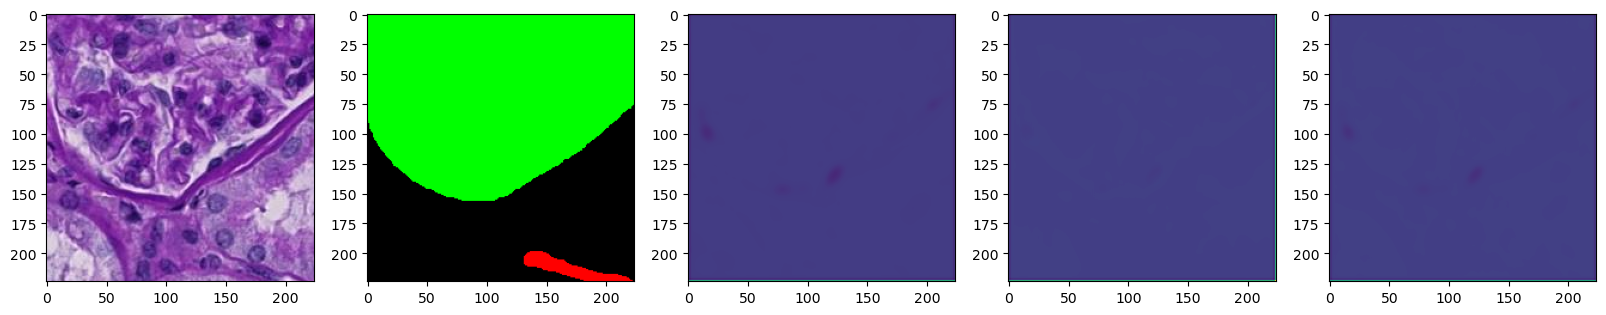

4m 18s
##################################################
Epoch 2/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.749569 || diceBCE: 2.241563 || IoU: 0.164948 || FT: 0.676324 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.820058 || diceBCE: 2.270356 || IoU: 0.123051 || FT: 0.769236 ||
--------------------------------------------------


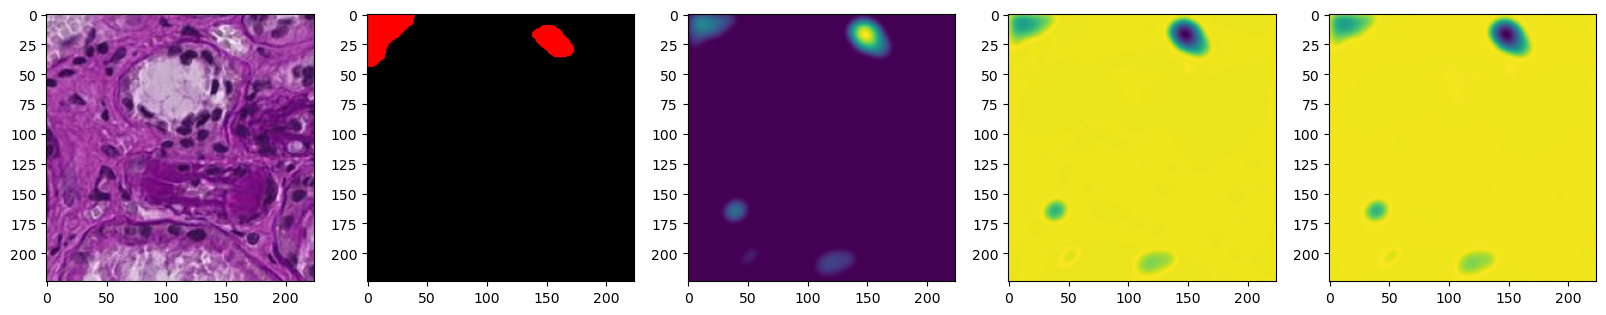

4m 21s
##################################################
Epoch 3/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.725201 || diceBCE: 2.137282 || IoU: 0.184063 || FT: 0.643544 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.778238 || diceBCE: 2.741654 || IoU: 0.164791 || FT: 0.736775 ||
--------------------------------------------------


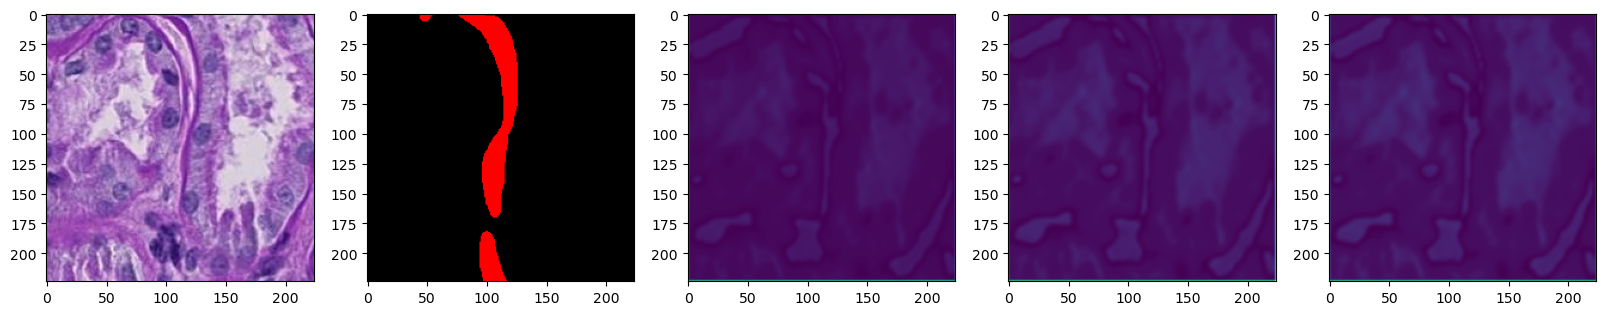

4m 19s
##################################################
Epoch 4/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.725036 || diceBCE: 2.232981 || IoU: 0.185646 || FT: 0.645871 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.776454 || diceBCE: 2.784137 || IoU: 0.160811 || FT: 0.729541 ||
--------------------------------------------------


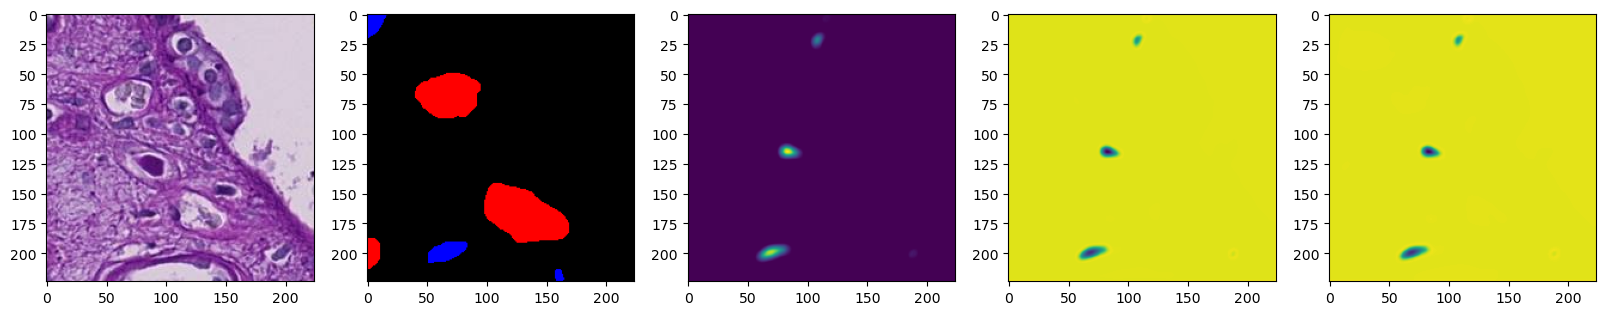

4m 18s
##################################################
Epoch 5/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.714726 || diceBCE: 2.745377 || IoU: 0.192866 || FT: 0.633743 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.803925 || diceBCE: 3.383282 || IoU: 0.134950 || FT: 0.754182 ||
--------------------------------------------------


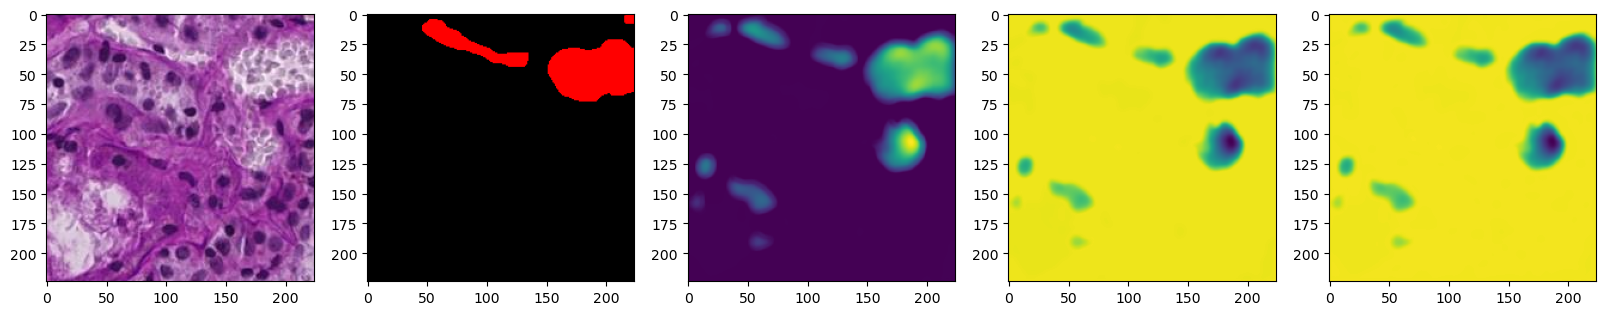

4m 17s
##################################################
Epoch 6/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.716390 || diceBCE: 2.593507 || IoU: 0.191920 || FT: 0.635076 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.770603 || diceBCE: 3.266022 || IoU: 0.169607 || FT: 0.725537 ||
--------------------------------------------------


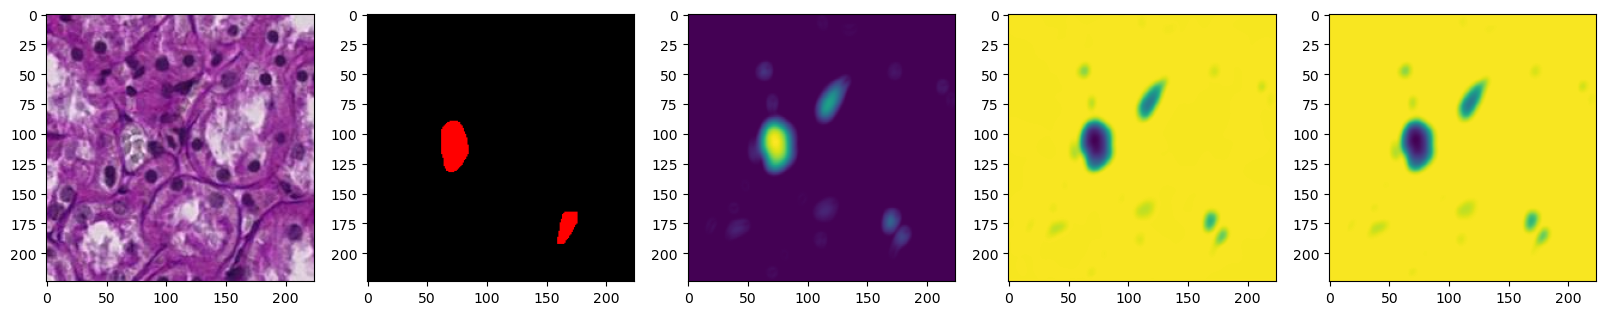

4m 16s
##################################################
Epoch 7/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.708697 || diceBCE: 2.784446 || IoU: 0.200440 || FT: 0.626106 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.791174 || diceBCE: 4.244261 || IoU: 0.144451 || FT: 0.753586 ||
--------------------------------------------------


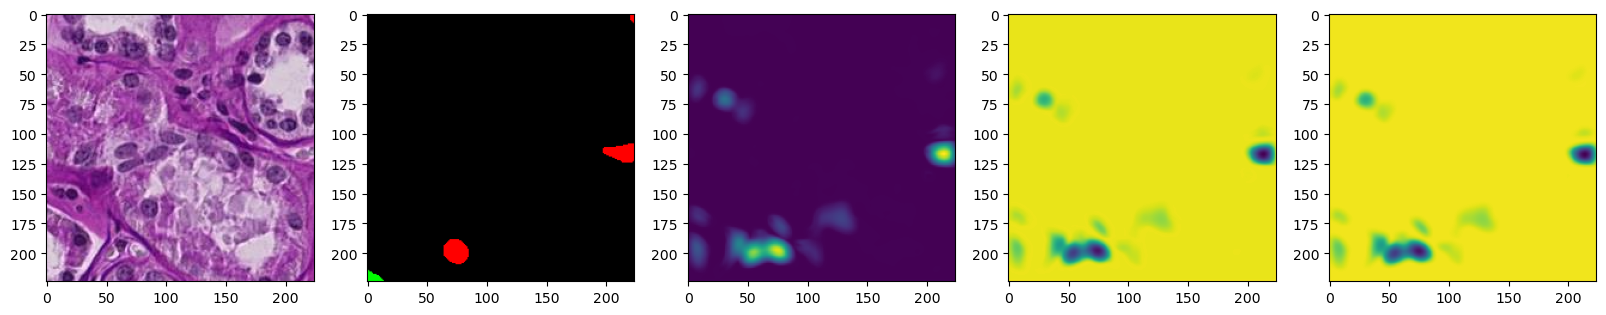

4m 16s
##################################################
Epoch 8/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.685884 || diceBCE: 2.780922 || IoU: 0.217313 || FT: 0.599017 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.747499 || diceBCE: 4.144768 || IoU: 0.189636 || FT: 0.705426 ||
--------------------------------------------------


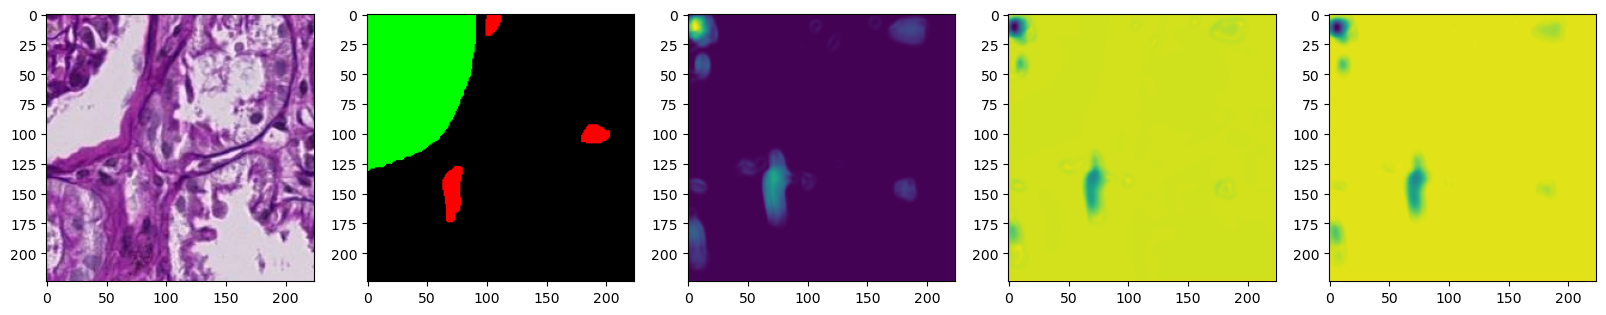

4m 15s
##################################################
Epoch 9/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.678081 || diceBCE: 3.299048 || IoU: 0.223668 || FT: 0.590395 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.752787 || diceBCE: 3.981260 || IoU: 0.184107 || FT: 0.708921 ||
--------------------------------------------------


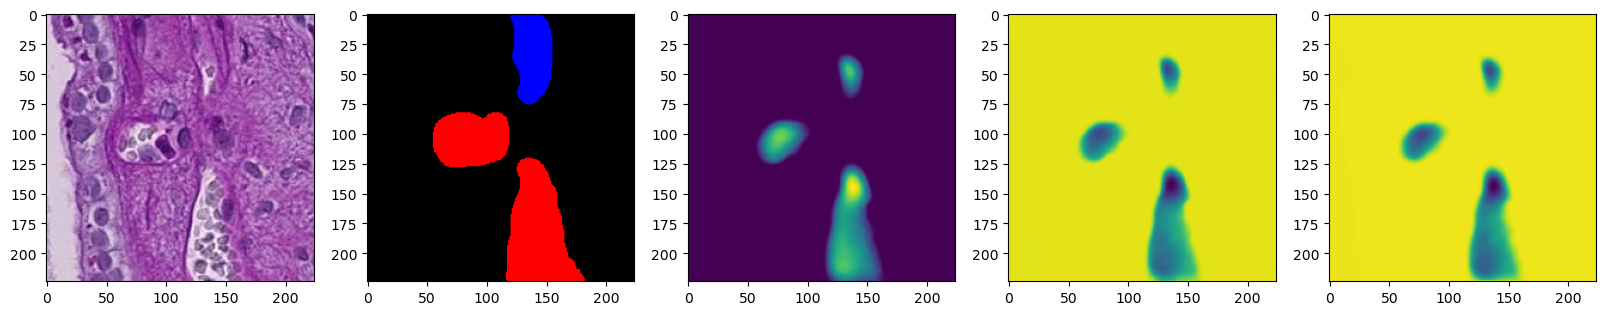

4m 15s
##################################################
Epoch 10/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.667198 || diceBCE: 2.936087 || IoU: 0.232603 || FT: 0.573778 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.755787 || diceBCE: 3.223874 || IoU: 0.178367 || FT: 0.708350 ||
--------------------------------------------------


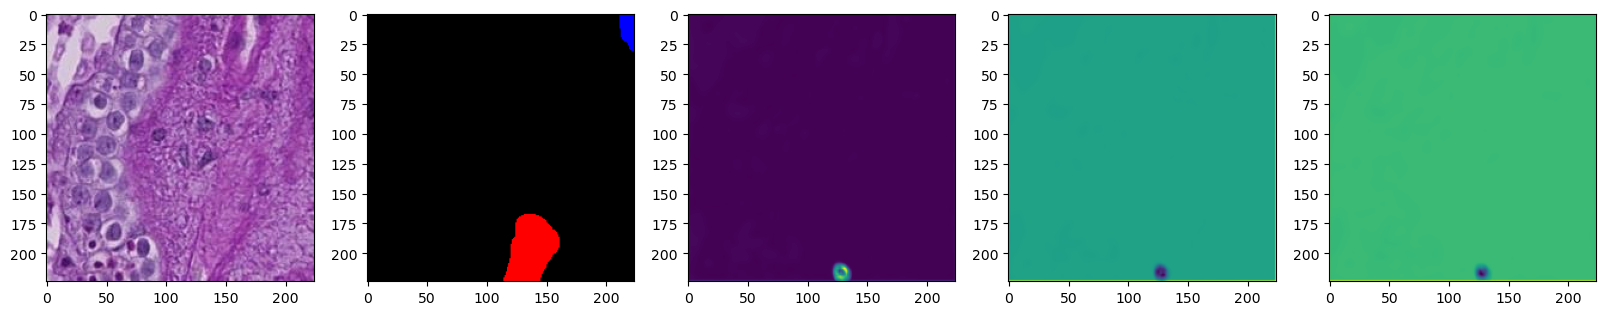

4m 14s
##################################################
Epoch 11/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.658348 || diceBCE: 3.034636 || IoU: 0.242201 || FT: 0.566442 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.780328 || diceBCE: 4.578921 || IoU: 0.159014 || FT: 0.742352 ||
--------------------------------------------------


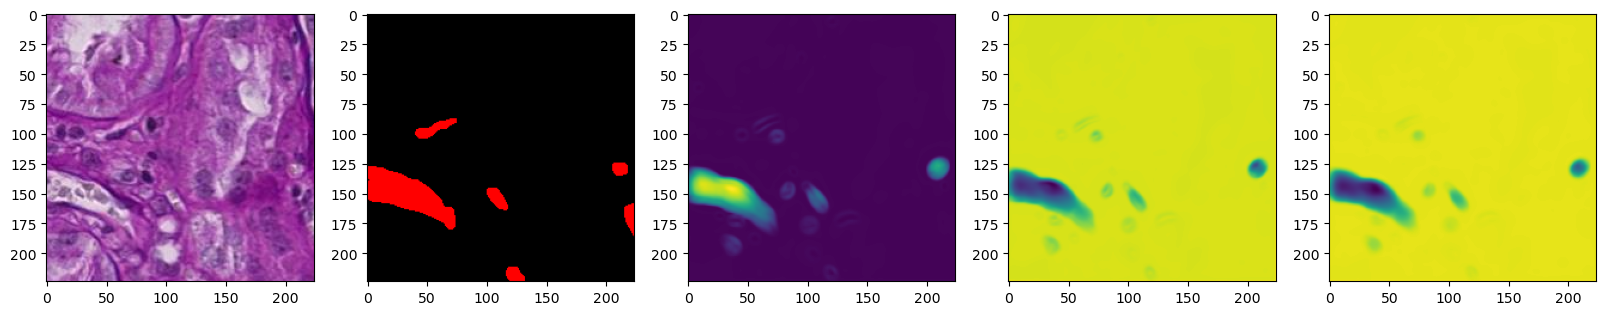

4m 17s
##################################################
Epoch 12/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.660410 || diceBCE: 2.997762 || IoU: 0.239096 || FT: 0.566732 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.724941 || diceBCE: 3.398038 || IoU: 0.210319 || FT: 0.685268 ||
--------------------------------------------------


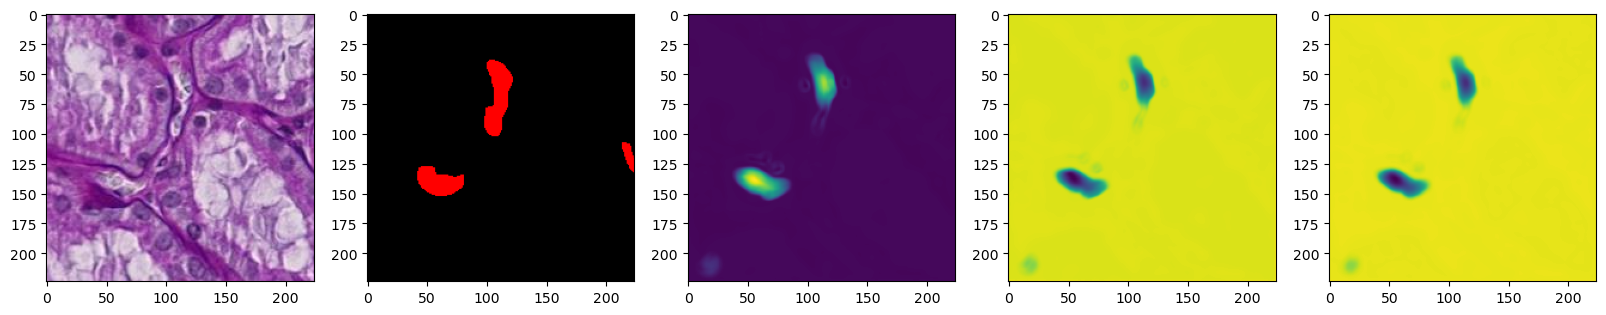

4m 16s
##################################################
Epoch 13/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.647665 || diceBCE: 3.043622 || IoU: 0.252598 || FT: 0.557676 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.743586 || diceBCE: 3.391452 || IoU: 0.197853 || FT: 0.692549 ||
--------------------------------------------------


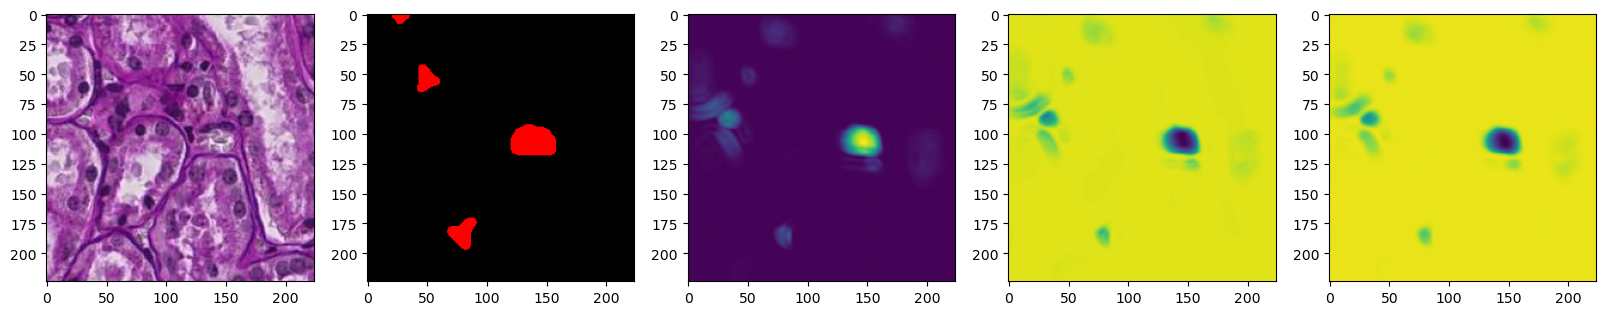

4m 14s
##################################################
Epoch 14/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.637187 || diceBCE: 3.012073 || IoU: 0.260593 || FT: 0.541493 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.745019 || diceBCE: 3.486661 || IoU: 0.191710 || FT: 0.695232 ||
--------------------------------------------------


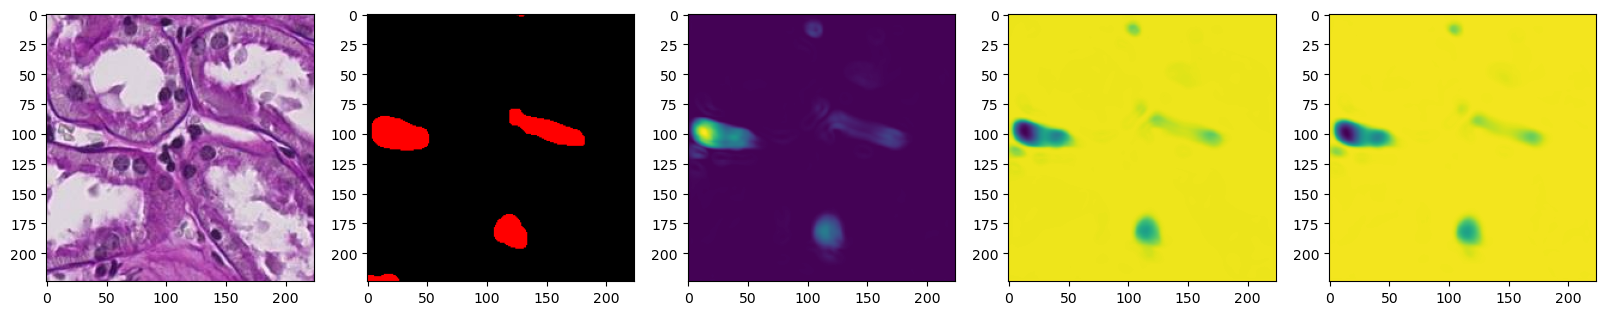

4m 15s
##################################################
Epoch 15/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.636593 || diceBCE: 2.920803 || IoU: 0.261984 || FT: 0.544730 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.796236 || diceBCE: 5.226980 || IoU: 0.142462 || FT: 0.763178 ||
--------------------------------------------------


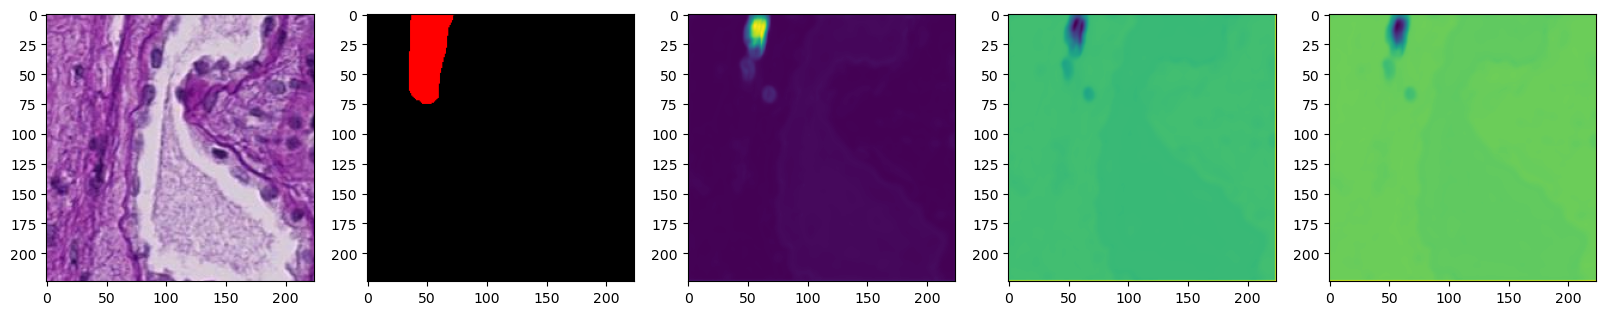

4m 15s
##################################################
Epoch 16/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.617933 || diceBCE: 2.899981 || IoU: 0.277839 || FT: 0.524299 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.714376 || diceBCE: 3.203856 || IoU: 0.222730 || FT: 0.661114 ||
--------------------------------------------------


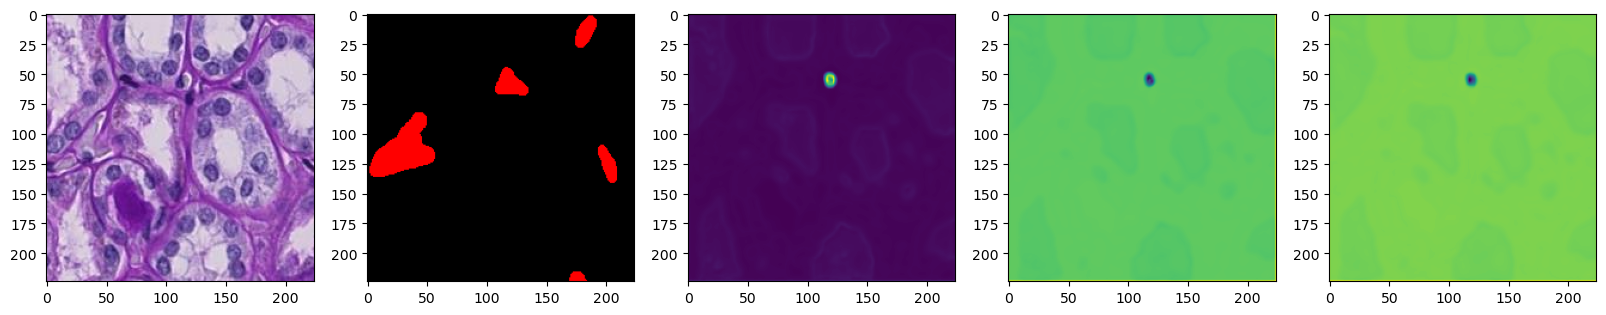

4m 14s
##################################################
Epoch 17/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.610024 || diceBCE: 2.983364 || IoU: 0.285771 || FT: 0.514890 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.768720 || diceBCE: 4.632663 || IoU: 0.168934 || FT: 0.726389 ||
--------------------------------------------------


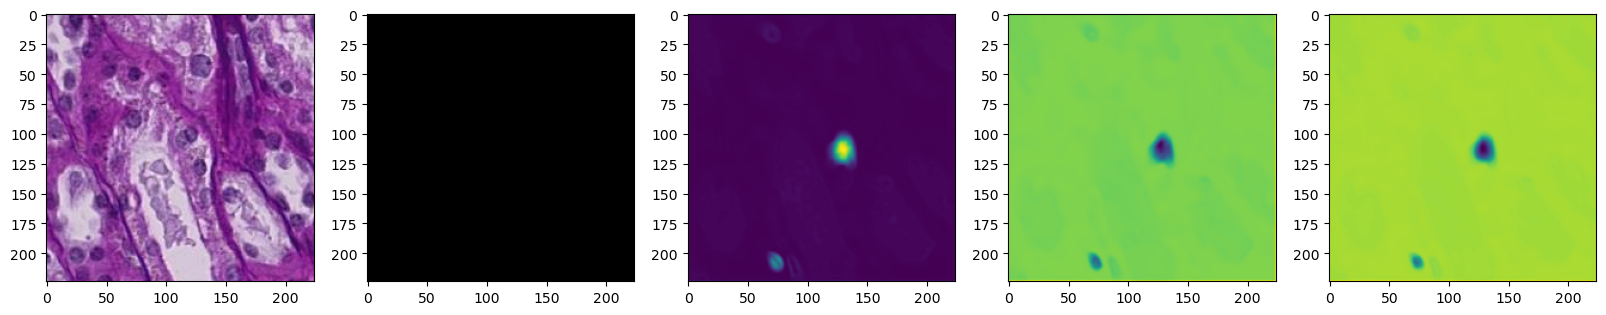

4m 14s
##################################################
Epoch 18/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.608401 || diceBCE: 2.979435 || IoU: 0.286134 || FT: 0.514285 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.741414 || diceBCE: 3.613596 || IoU: 0.197690 || FT: 0.684584 ||
--------------------------------------------------


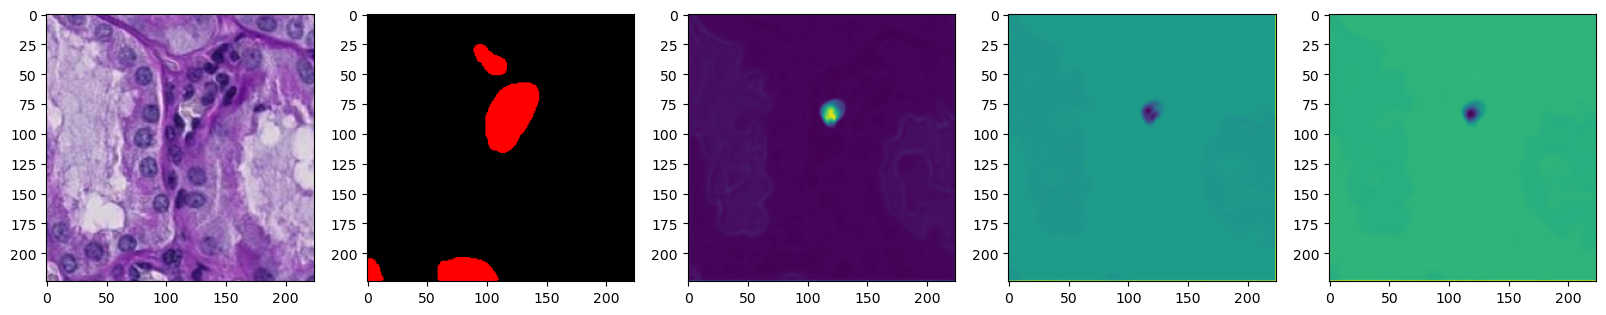

4m 26s
##################################################
Epoch 19/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.610261 || diceBCE: 3.075402 || IoU: 0.283842 || FT: 0.514646 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.718192 || diceBCE: 3.580668 || IoU: 0.221579 || FT: 0.662472 ||
--------------------------------------------------


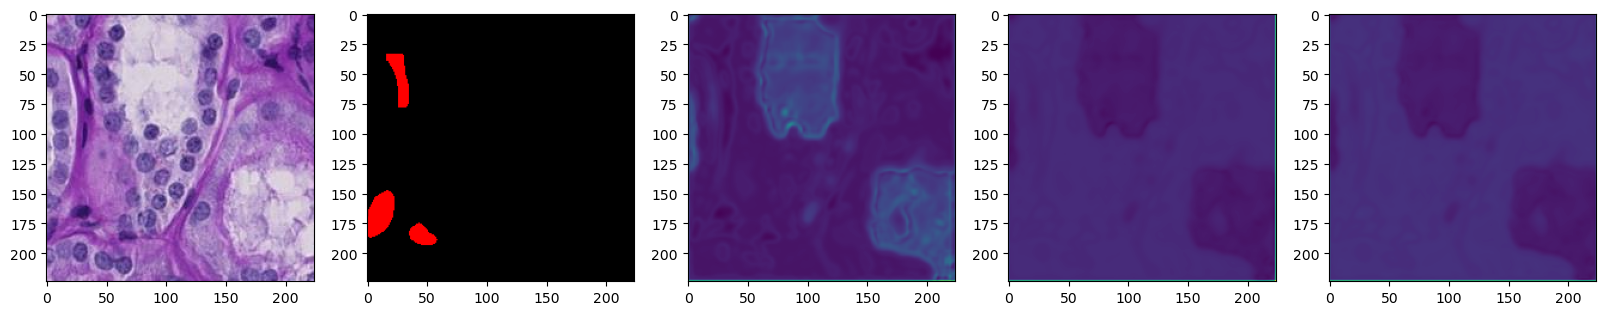

4m 20s
##################################################
Epoch 20/20: 
Phase: train


  0%|          | 0/1306 [00:00<?, ?batch/s]

train: || dice: 0.606720 || diceBCE: 2.927357 || IoU: 0.289572 || FT: 0.514213 ||
--------------------------------------------------
Phase: val


  0%|          | 0/327 [00:00<?, ?batch/s]

val: || dice: 0.718706 || diceBCE: 3.593570 || IoU: 0.212682 || FT: 0.667484 ||
--------------------------------------------------


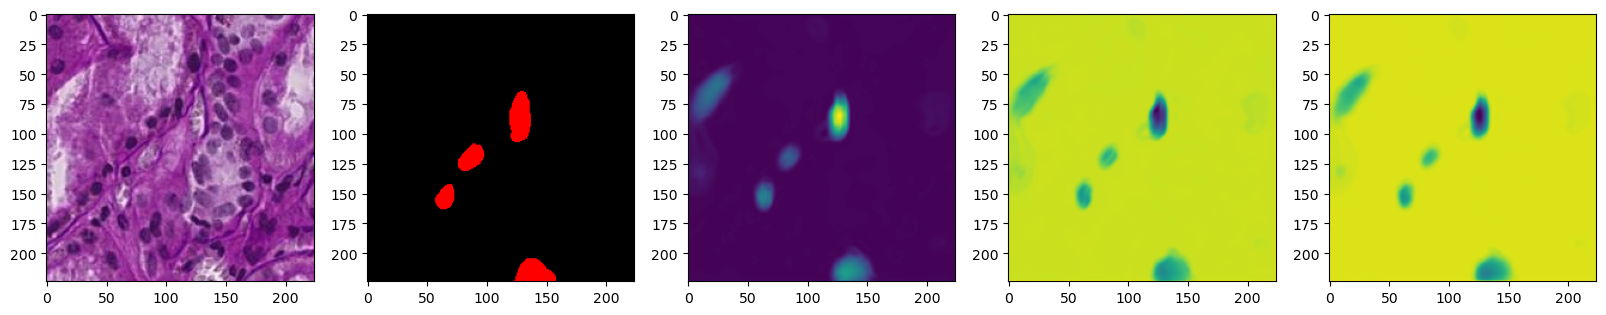

4m 20s
##################################################
Best validation loss: 0.661114


In [26]:
model = train(get_UnetPlusPlus101, 'Unet++', "SHdataset/labeled", classes = [0,1,2])

In [37]:
metrics = model[1]
train_FT = [metrics['train'][i]['FT']/1306. for i in range(len(metrics['train']))]
train_IoU = [metrics['train'][i]['IoU']/1306.0 for i in range(len(metrics['train']))]
train_dice = [metrics['train'][i]['dice']/1306.0 for i in range(len(metrics['train']))]
train_diceBCE = [metrics['train'][i]['diceBCE']/1306.0 for i in range(len(metrics['train']))]

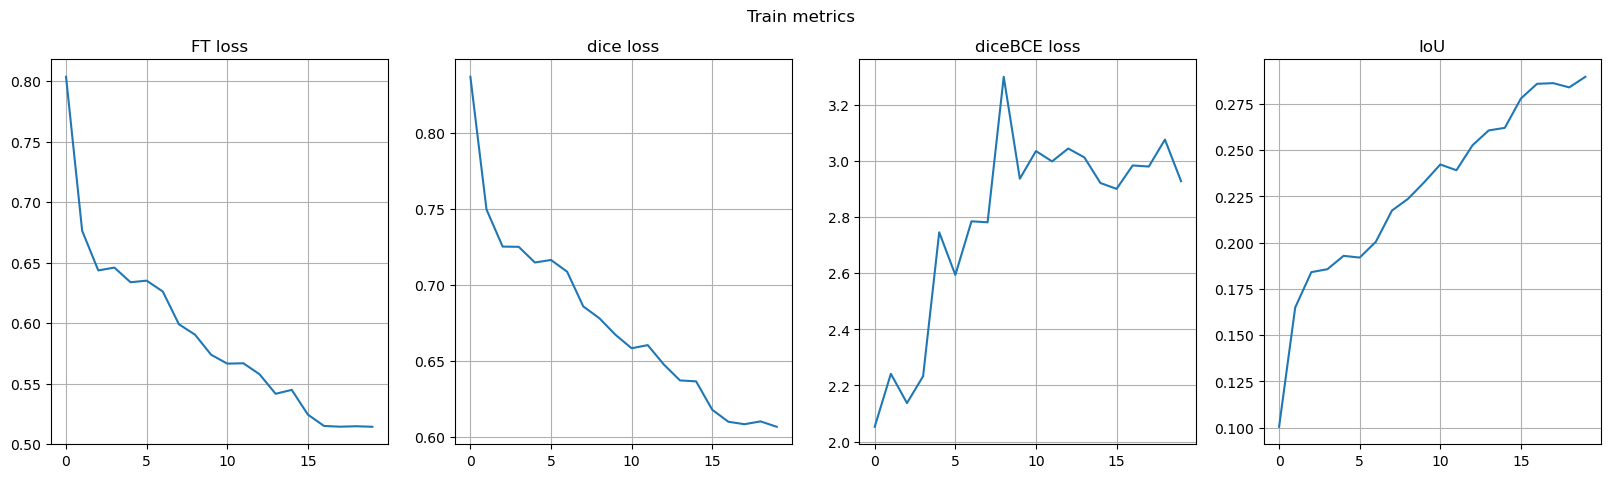

In [40]:
fig, ax = plt.subplots(1,4, figsize = (20,5))
fig.suptitle("Train metrics")
titles = ["FT loss", "dice loss", "diceBCE loss", "IoU"]
for a in range(len(ax)):
    ax[a].grid()
    ax[a].set_title(titles[a])
ax[0].plot(range(0,20), train_FT)
ax[1].plot(range(0,20), train_dice)
ax[2].plot(range(0,20), train_diceBCE)
ax[3].plot(range(0,20), train_IoU)
plt.show()

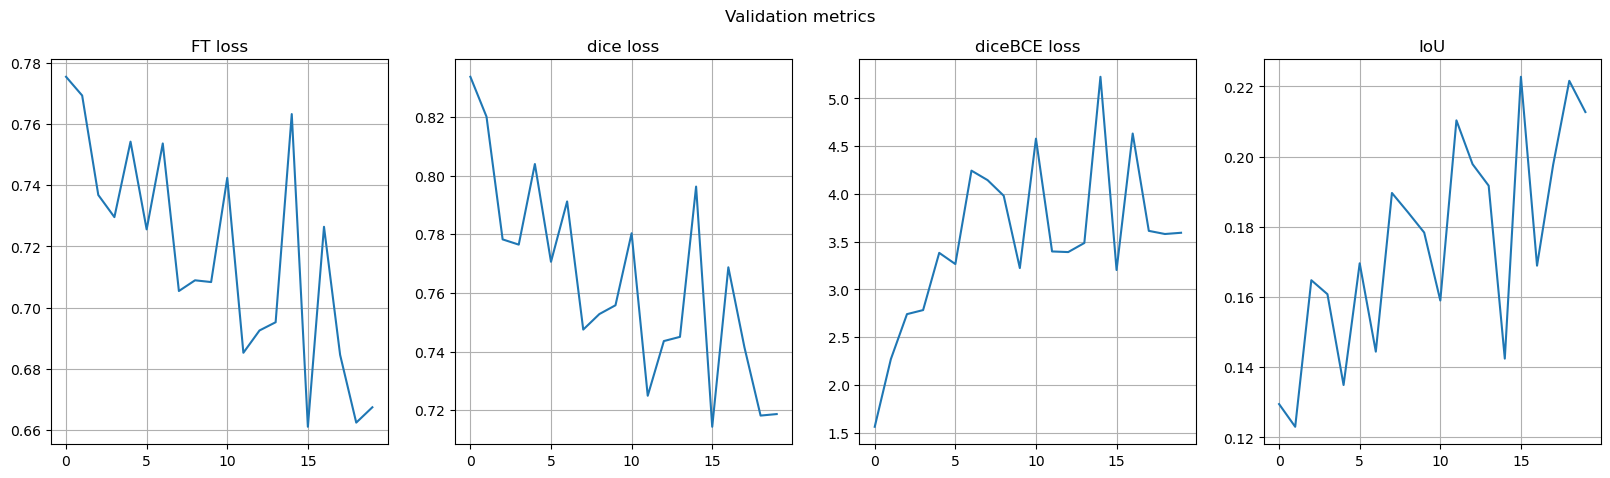

In [41]:
val_FT = [metrics['val'][i]['FT']/327 for i in range(len(metrics['val']))]
val_IoU = [metrics['val'][i]['IoU']/327 for i in range(len(metrics['val']))]
val_dice = [metrics['val'][i]['dice']/327 for i in range(len(metrics['val']))]
val_diceBCE = [metrics['val'][i]['diceBCE']/327 for i in range(len(metrics['val']))]

fig, ax = plt.subplots(1,4, figsize = (20,5))
fig.suptitle("Validation metrics")
titles = ["FT loss", "dice loss", "diceBCE loss", "IoU"]
for a in range(len(ax)):
    ax[a].grid()
    ax[a].set_title(titles[a])
ax[0].plot(range(0,20), val_FT)
ax[1].plot(range(0,20), val_dice)
ax[2].plot(range(0,20), val_diceBCE)
ax[3].plot(range(0,20), val_IoU)
plt.show()